<h2><center> Tomography Reconstruction using CIL </center></h2>

### In this demo, we reconstruct simulated tomographic data using:

* the Filtered Back Projection (FBP) algorithm, 
* Total variation (TV) regularisation under a non-negativity constraint

    <a id='tv_reg'></a>
    $$\begin{equation}
    \underset{u}{\operatorname{argmin}} \frac{1}{2} \| A u - g\|^{2}_{2} + \alpha\,\mathrm{TV}(u) + \mathbb{I}_{\{u\geq0\}}(u)
    \tag{1}
    \end{equation}$$

    where,

    * g is a noisy data corrupted with Gaussian noise and
    * $A$ is the Projection operator.

In [1]:
# Import libraries

from cil.framework import  AcquisitionGeometry

from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D, show_geometry
from cil.utilities import noise

import matplotlib.pyplot as plt

import numpy as np


Bad key "text.kerning_factor" on line 4 in
/home/vaggelis/miniconda3/envs/cil_binder_intel/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


We first configure our acquisition geometry, e.g., **2D parallel geometry**. Then, the image geometry is extracted and used to configure our phantom. To create our simulated phantoms, we use the [Tomophantom](https://github.com/dkazanc/TomoPhantom) library.

In [2]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

Next, we create our simulated tomographic data by projecting our noiseless `phantom` to the acquisition space. Using the image geometry `ig` and acquisition geometry `ag`, we define the `ProjectionOperator` with `device=cpu` or `device=gpu`. Finally,  Gaussian noise is added to the noiseless sinogram.

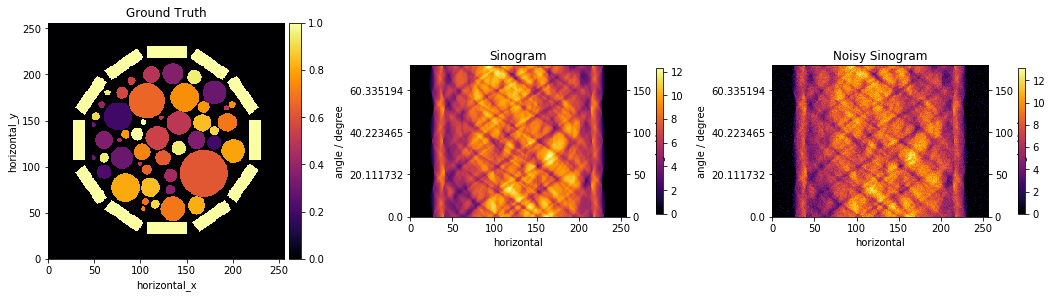

In [3]:
# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'cpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title = ['Ground Truth','Sinogram','Noisy Sinogram'], num_cols=3, cmap = 'inferno')


For our first reconstruction, we use the Filtered BackProjection algorithm, i.e., `FBP` applied to our noisy sinogram `noisy_sino`.

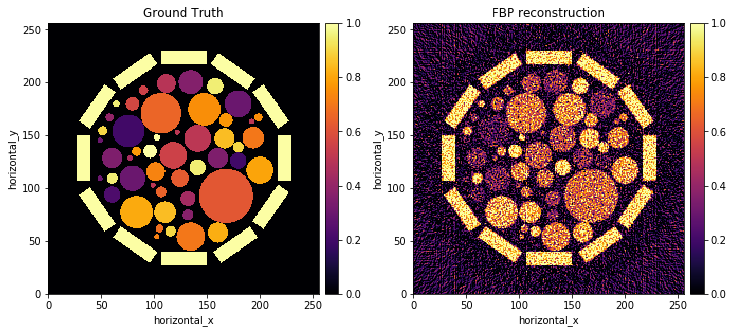

In [4]:
# Setup and run the FBP algorithm
fbp_recon = FBP(ig, ag,  device = 'gpu')(noisy_sino)

# Show reconstructions
show2D([phantom, fbp_recon], 
       title = ['Ground Truth','FBP reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))

In the above reconstruction noise is not penalised. In order to remove noise artifacts, we will use the TotalVariation regularisation as shown in the minimisation problem above.

We solve [(1)](#tv_reg), using the **Primal-Dual Hybrid Gradient (PDHG)** algorithm introduced in [ChambollePock](https://link.springer.com/article/10.1007/s10851-010-0251-1). We need to write [(1)](#tgv_reg) in the following general form $$\underset{x\in \mathbb{X} }{\operatorname{argmin}} f(Kx) + g(x).$$

We let $x=u$ and

* define an operator $K:\mathbb{X}\rightarrow\mathbb{Y}$ as$\\[10pt]$

    $$\begin{equation}
    K = 
    \begin{bmatrix}
    A \\
    D 
    \end{bmatrix} \quad\Rightarrow\quad
    Kx = Ku = 
    \begin{bmatrix}
    \mathcal{A}u\\
    Du\\
    \end{bmatrix} =
    \begin{bmatrix}
    y_{1}\\
    y_{2}
    \end{bmatrix} = y\in \mathbb{Y},
    \label{def_K}
    \end{equation}$$ 
    
* define a function $f:\mathbb{Y}\rightarrow\mathbb{R}$ as$\\[10pt]$

    $$\begin{equation}
    \begin{aligned}
    & f(y)  := f(y_{1}, y_{2}) = f_{1}(y_{1}) +  f_{2}(y_{2}) , \mbox{ where},\\[10pt]
    & f_{1}(y_{1}) :=  \frac{1}{2}\| y_{1} - g\|_{2}^{2},\, f_{2}(y_{2}) :=  \alpha \|y_{2}\|_{2,1}
    \end{aligned}
    \label{def_f}
    \end{equation}\\[10pt]$$
    
* and define a function $g(x) = g(u) = \mathbb{I}_{\{u\geq0\}}(u)$ for the non-negativity constraint.



In [5]:
# Define BlockOperator K
Grad = GradientOperator(ig)
K = BlockOperator(A, Grad)

# Define BlockFunction f
alpha = 0.1
f1 = 0.5 * L2NormSquared(b=noisy_sino)
f2 = alpha * MixedL21Norm()
f = BlockFunction(f1, f2)

# Define Function g
g = IndicatorBox(lower=0)

# Primal/Dual stepsizes
normK = K.norm()
sigma = 1./normK
tau = 1./normK

# Setup and run PDHG
pdhg = PDHG(f = f, g = g, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 500,
            update_objective_interval = 100)
pdhg.run(verbose=2)

Initialised GradientOperator with C backend running with  16  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000    1.03592e+06  -0.00000e+00    1.03592e+06


/home/vaggelis/miniconda3/envs/cil_binder_intel/lib/python3.7/site-packages/cil/framework/framework.py:2182: RuntimeWarning: divide by zero encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )
/home/vaggelis/miniconda3/envs/cil_binder_intel/lib/python3.7/site-packages/cil/framework/framework.py:2182: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100        500         0.314    7.70116e+03   6.79275e+03    9.08407e+02
      200        500         0.271    7.59639e+03   7.46030e+03    1.36088e+02
      300        500         0.256    7.58777e+03   7.56032e+03    2.74545e+01
      400        500         0.247    7.58594e+03   7.57595e+03    9.98134e+00
      500        500         0.243    7.58514e+03   7.57943e+03    5.70734e+00
----------------------------------------------------------------------------
      500        500         0.243    7.58514e+03   7.57943e+03    5.70734e+00
Stop criterion has been reached.



Finally, we compare the PDHG and FBP reconstructions and plot the middle line profiles.

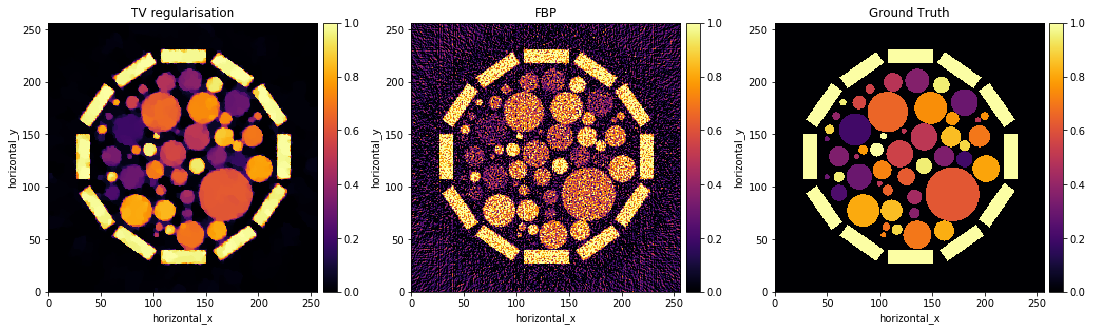

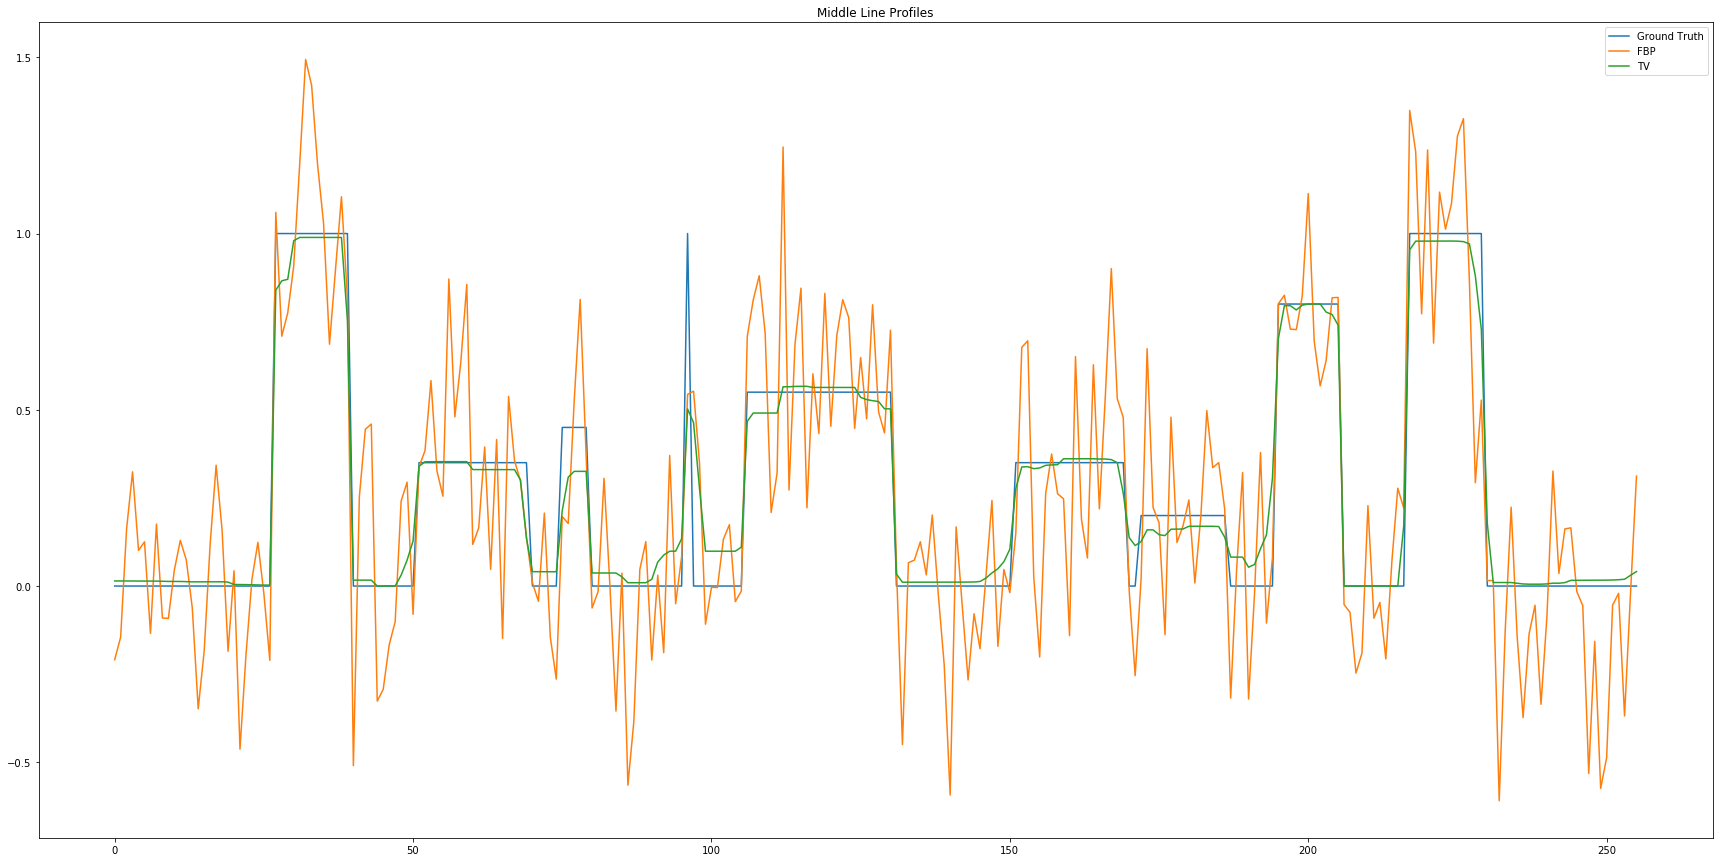

In [6]:
show2D([pdhg.solution,fbp_recon, phantom], title = ['TV regularisation','FBP','Ground Truth'], cmap = 'inferno', num_cols=3, fix_range=(0,1.))

# Plot middle line profile
plt.figure(figsize=(30,15))
plt.plot(phantom.subset(horizontal_y = int(N/2)).as_array(), label = 'Ground Truth')
plt.plot(fbp_recon.subset(horizontal_y = int(N/2)).as_array(), label = 'FBP')
plt.plot(pdhg.solution.subset(horizontal_y = int(N/2)).as_array(), label = 'TV')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()